# Abstract - MobileNetV3(2019)

* NetAdapt 알고리즘이 적용된 NAS(Neural architecture search)을 사용하여 구조를 탐색하고 탐색한 구조를 수정하여 성능을 개선한 모델이다.
  - 효율적인 아키텍처 탐색 기법은 기본적으로 강화학습(Reinforcement Learning) 기법 적용
  - NAS로 초기 모델 구조(MnasNet-A1)를 찾은 다음, NetAdapt 및 다른 optimization 적용하여 구축
  - NAS를 통해 찾은 초기 모델 구조 MnasNet-A1는 마지막 layer와 초기 layer의 연산량이 많다는 것을 발견하여 해당 layer 들을 수정함.
    - latency를 감소하고 high dimensional feature를 보존하기 위해 마지막 몇개의 layer를 global average pooling 이후에 위치하도록 이동시킨다.(7 by 7 featuremap -> 1 by 1 featuremap 에서 특징을 추출하게 되므로 연산량이 적다)
    - 초기에 연산량이 많은 layer의 비선형 함수를 h-swish로 대체(Relu 대신 h-swish 비선형 함수를 사용하면 연산량을 유지하면서 32개의 필터를 16개로 감소시켜 속도 향상 효과가 있음)

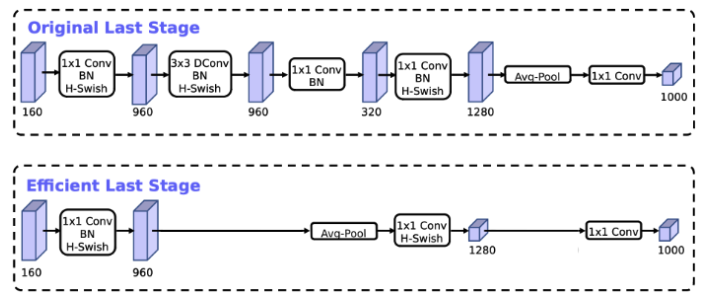

* 새로운 비선형 함수인 h-swish
  - h_swish(x) = x * ReLu6(x+3)/6
  - 모든 layer에서 h-swish를 사용하는건 아니고 relu 함수와 섞어 사용하면 성능이 더욱 향상됨을 실험적으로 확인함.
    - 모델 layer의 처음 절반은 relu 사용, 이후 깊은 layer에 해당되는 절반은 h-swish 사용하는 방식

In [ ]:
class HardSwish(nn.Module):
    def forward(self,x):
        return x*(F.relu6(x+3)/6)

* 기본적으로 MobileNetV2 구조를 기반으로 하는 구조이며, bottleneck 구조에 SENet 에서 제안되었던 squeeze & excitation block(SE block)을 사용함
  - 이때, 기존 SE block에서 사용한 sigmoid는 hard sigmoid로 대체하여 사용하고 swish 비선형 함수는 더 효과적인 hard swish를 사용
  - SE block의 채널 수를 bottleneck의 expansion layer의 1/4로 설정. 이렇게 하여 성능이 향상됨을 실험적으로 확인.


* depthwise separable convolution을 반복해서 사용하기때문에, 이를 mobile_block 이라는 함수로 묶어둠

In [1]:
import torch.nn as nn

def mobile_block(in_dim, out_dim, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=3, stride=stride, padding=1, groups=in_dim),
        nn.BatchNorm2d(in_dim),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(inplace=True),
    )

class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            mobile_block(32, 64),
            mobile_block(64, 128, 2),
            mobile_block(128, 128),
            mobile_block(128, 256, 2),
            mobile_block(256, 256),
            mobile_block(256, 512, 2),
            *[mobile_block(512, 512) for _ in range(5)],
            mobile_block(512, 1024, 2),
            mobile_block(1024, 1024),

            nn.AvgPool2d(7),
        )
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* MobileNetv3는 Mobile Phone CPU에 최적화되어, NetAdapt와 NAS를 조합하여 새로운 구조를 제안함.


* Mobile 환경에서 classification, detection, segmentation task에서 SOTA를 달성

* tensorflow keras에서 아래와 같이 간단하게 구현할 수 있다.

In [ ]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='')